# Regression 

In [39]:
import numpy as np
import sympy as sp
import pymc as pm
import arviz as az
import xarray as xr
import pytensor.tensor as pt
import pytensor
import matplotlib.pyplot as plt
import seaborn as sb
from typing import Callable, Dict, List, Optional, Tuple, Union
from ipywidgets import interact, FloatSlider, fixed
import ipywidgets
import panel as pn

pn.extension()

## First A Little Linear Algebra

Regression is often taught starting as though this magical formula just appears out of nowhere:

$$ y = X\beta + \epsilon$$

The problem with doing that is it obscures the basic mathematical operations underlying it, leading to some level of confusion about what can and cannot be said about the results from a regression estimator (e.g. undue reliance on $R^2$ or $p$-values as determining factors in the utility of results). The purpose of this notebook is to unpack the basic maths of the least-squares problem in an effort to unlock use cases that may not have been previously considered valid.

The first thing to note is the word linear, which appears both in linear algebra and linear regression. This is not an accident. A linear space generally is just one that follows a set of rules, but fundamentally it's just a space that admits addition and multiplication. If we can add a bunch of numbers up and scale them with multiplication, we are in pretty good shape, whether or not we are dealing with single numbers or matrices.

Most folks are fine with the following examples of addition and scaling via multiplication:

$$ 
\begin{bmatrix} a_{0,0} \quad a_{0,1} \\ a_{1,0} \quad a_{1,1} \end{bmatrix} 
\begin{bmatrix} b_{0,0} \quad b_{0,1} \\ b_{1,0} \quad b_{1,1} \end{bmatrix} = 
\begin{bmatrix} a_{0,0} + b_{0,0} \quad a_{0,1} + b_{0,1} \\ a_{1,0} + b_{1,0} \quad a_{1,1} + b_{1,1} \end{bmatrix} 
$$

$$ 
c \begin{bmatrix} a_{0,0} \quad a_{0,1} \\ a_{1,0} \quad a_{1,1} \end{bmatrix} =
\begin{bmatrix} ca_{0,0} \quad ca_{0,1} \\ ca_{1,0} \quad ca_{1,1} \end{bmatrix} 
$$

However, when it comes to matrix multiplication, things get hairy.
$$ 
\begin{bmatrix} a_{0,0} \quad a_{0,1} \\ a_{1,0} \quad a_{1,1} \end{bmatrix}
\begin{bmatrix} b_0 \\ b_1 \end{bmatrix} = ??
$$

The key is to recognize we are dealing with linear systems of equations. Even in the addition case, we are computing a collection of equations.

$$
\begin{align}
a_{0,0} + b_{0,0} &= a_{0,0} + b_{0,0} \\
a_{0,1} + b_{0,1} &= a_{0,1} + b_{0,1} \\
a_{1,0} + b_{1,0} &= a_{1,0} + b_{1,0} \\
a_{1,1} + b_{1,1} &= a_{1,1} + b_{1,1}
\end{align}
$$

In the matrix multiplication case, we are just distributing the multiplication by same values of $b = [b_0, b_1]$ across each row in our data $A = \begin{bmatrix} a_{0,0} \quad a_{0,1} \\ a_{1,0} \quad a_{1,1} \end{bmatrix}$.

$$ 
\begin{bmatrix} a_{0,0} \quad a_{0,1} \\ a_{1,0} \quad a_{1,1} \end{bmatrix}
\begin{bmatrix} b_0 \\ b_1 \end{bmatrix} \quad \rightarrow \quad
\begin{align}
a_{0,0} b_0 + a_{1,0} b_1 &= c_0 \\
a_{0,1} b_0  + a_{1,1} b_1 &= c_1 \\
\end{align}
$$

It's just a compact way to write it down. Even more compactly...

$$Ab = c$$

Let's use some real data.

In [2]:
a: np.array = np.array([[1, 2], [3, 4]])
b: np.array = np.array([1, 2])
c: np.array = a.dot(b)

print("A")
print(a)
print("b")
print(b)
print("c")
print(c)

A
[[1 2]
 [3 4]]
b
[1 2]
c
[ 5 11]


In other words...

$$
\begin{align}
(1)(1) + (2)(2) &= 5 \\
(3)(1) + (4)(2) &= 11
\end{align}
$$

## The [Least Squares Problem](https://www.youtube.com/watch?v=AmQcoopBUTk)

Often we want to compute that vector $b$, which we can think of as weights or a measure of the relationship between to variables $A$ and $c$. Doing so seems kind of straightforward. If this is our system...

$$Ab=c$$

...intuitively, we want something like the following:

$$b = \frac{c}{A}$$

We can achieve this by multiplying by the inverse of $A$.

$$
\begin{align}
A^{-1}Ab &= A^{-1}c \\
b &= A^{-1}c
\end{align}
$$

Finding inversions of matrices is a whole topic of it's own. Fortunately `numpy` can sweep all of that under the rug for us.

In [3]:
a_inv: np.array = np.linalg.inv(a)
print("A_inv")
print(a_inv)

A_inv
[[-2.   1. ]
 [ 1.5 -0.5]]


In [4]:
computed_b: np.array = a_inv.dot(c)
print("computed_b")
print(computed_b)
print("b == computed_b")
print(np.allclose(b, computed_b))

computed_b
[1. 2.]
b == computed_b
True


As lovely as it would be to stop here, we have a twist. Usually when we are trying to recover $b$ in the real world, we have some source of variation we can't directly see or account for (e.g. noise), which means we will not be able to compute $b$ in a way that exactly fits the data we see. We need to find the $b$ that best fits the data we observe, but what does it mean to have the best fit?

The Least Squares problem is so named because it relies on a very specific rule. The rule (or loss function) defines the best fit as the one in which $\Sigma_{i=0}^n(A_i b - c_i)^2$ is as small as possible. In other words, if we compute $\hat{c}$ from $Ab$ and compare it to $c$, we want the sum of squared differences to be minimized: *the least squares solution*.

So, how do we find that value of $b$? It turns out there are many ways, but in my mind the easiest way is to minimize a representation of squared residuals ($\epsilon^2$)via calculus. First, let's compute $\epsilon^2$...

$$
\begin{align}
y &= X\beta + \epsilon \\
\epsilon &= y - X\beta \\
\rightarrow \epsilon^2 &= (y - X\beta)'(y - X\beta) \\
&= y'y - y'X\beta - \beta'X'y + \beta'X'X\beta \\
&= y'y - 2y'X\beta + \beta'X'X\beta \\
\end{align}
$$

...and now we can minimize it with respect to $\beta$.

$$
\begin{align}
\frac{\partial \epsilon^2}{\partial \beta} &= \frac{\partial}{\partial \beta} (y'y - 2y'X\beta + \beta'X'X\beta) \\
&= -2y'X + 2X'X\beta \\
\rightarrow 0 &= -2y'X + 2X'X\beta \\
2y'X &= 2X'X\beta \\
y'X &= X'X\beta \\
(X'X)^{-1}y'X &= (X'X)^{-1}X'X\beta \\
\beta &=(X'X)^{-1}y'X \\
&=(X'X)^{-1}X'y \\
\end{align}
$$

If you are unfamiliar with calculus, it may look complicated, but all we are doing is saying let me take the expression $y'y - 2y'X\beta + \beta'X'X\beta$ and find the value of $\beta$ that makes it the smallest. The variance of $y$ ($y'y$)doesn't matter because it doesn't change when $\beta$ changes. All that matters is the variance of $X$ ($X'X$) and the covariance of $X$ and $y$ ($X'y$). If we divide $X'y$ by $X'X$, we are just putting variation in $y$ in terms of variation in $X$. 

### Simulating Data

There was a decent amount of algebra and statistical stuff above. Let's unpack it a bit with some actual data. We can simulate a known relationship. 

$$Y = 3 + 2X + \epsilon$$

Sampling: [e, x_obs]


Identity [id A] 'y'
 └─ Add [id B]
    ├─ Sum{axes=None} [id C]
    │  └─ Mul [id D]
    │     ├─ Identity [id E] 'x'
    │     │  └─ Join [id F]
    │     │     ├─ 0 [id G]
    │     │     ├─ Identity [id H] 'intercept'
    │     │     │  └─ Alloc [id I]
    │     │     │     ├─ 1.0 [id J]
    │     │     │     └─ 1 [id K]
    │     │     └─ normal_rv{"(),()->()"}.1 [id L] 'x_obs'
    │     │        ├─ RNG(<Generator(PCG64) at 0x775559A2E6C0>) [id M]
    │     │        ├─ [1] [id N]
    │     │        ├─ ExpandDims{axis=0} [id O]
    │     │        │  └─ 0 [id P]
    │     │        └─ ExpandDims{axis=0} [id Q]
    │     │           └─ 4 [id R]
    │     └─ Identity [id S] 'beta'
    │        └─ beta{[3. 2.]} [id T]
    └─ normal_rv{"(),()->()"}.1 [id U] 'e'
       ├─ RNG(<Generator(PCG64) at 0x775561CA6DC0>) [id V]
       ├─ NoneConst{None} [id W]
       ├─ 0 [id X]
       └─ 5 [id Y]


/home/choct155/tools/miniconda3/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


Inference data with groups:
	> prior

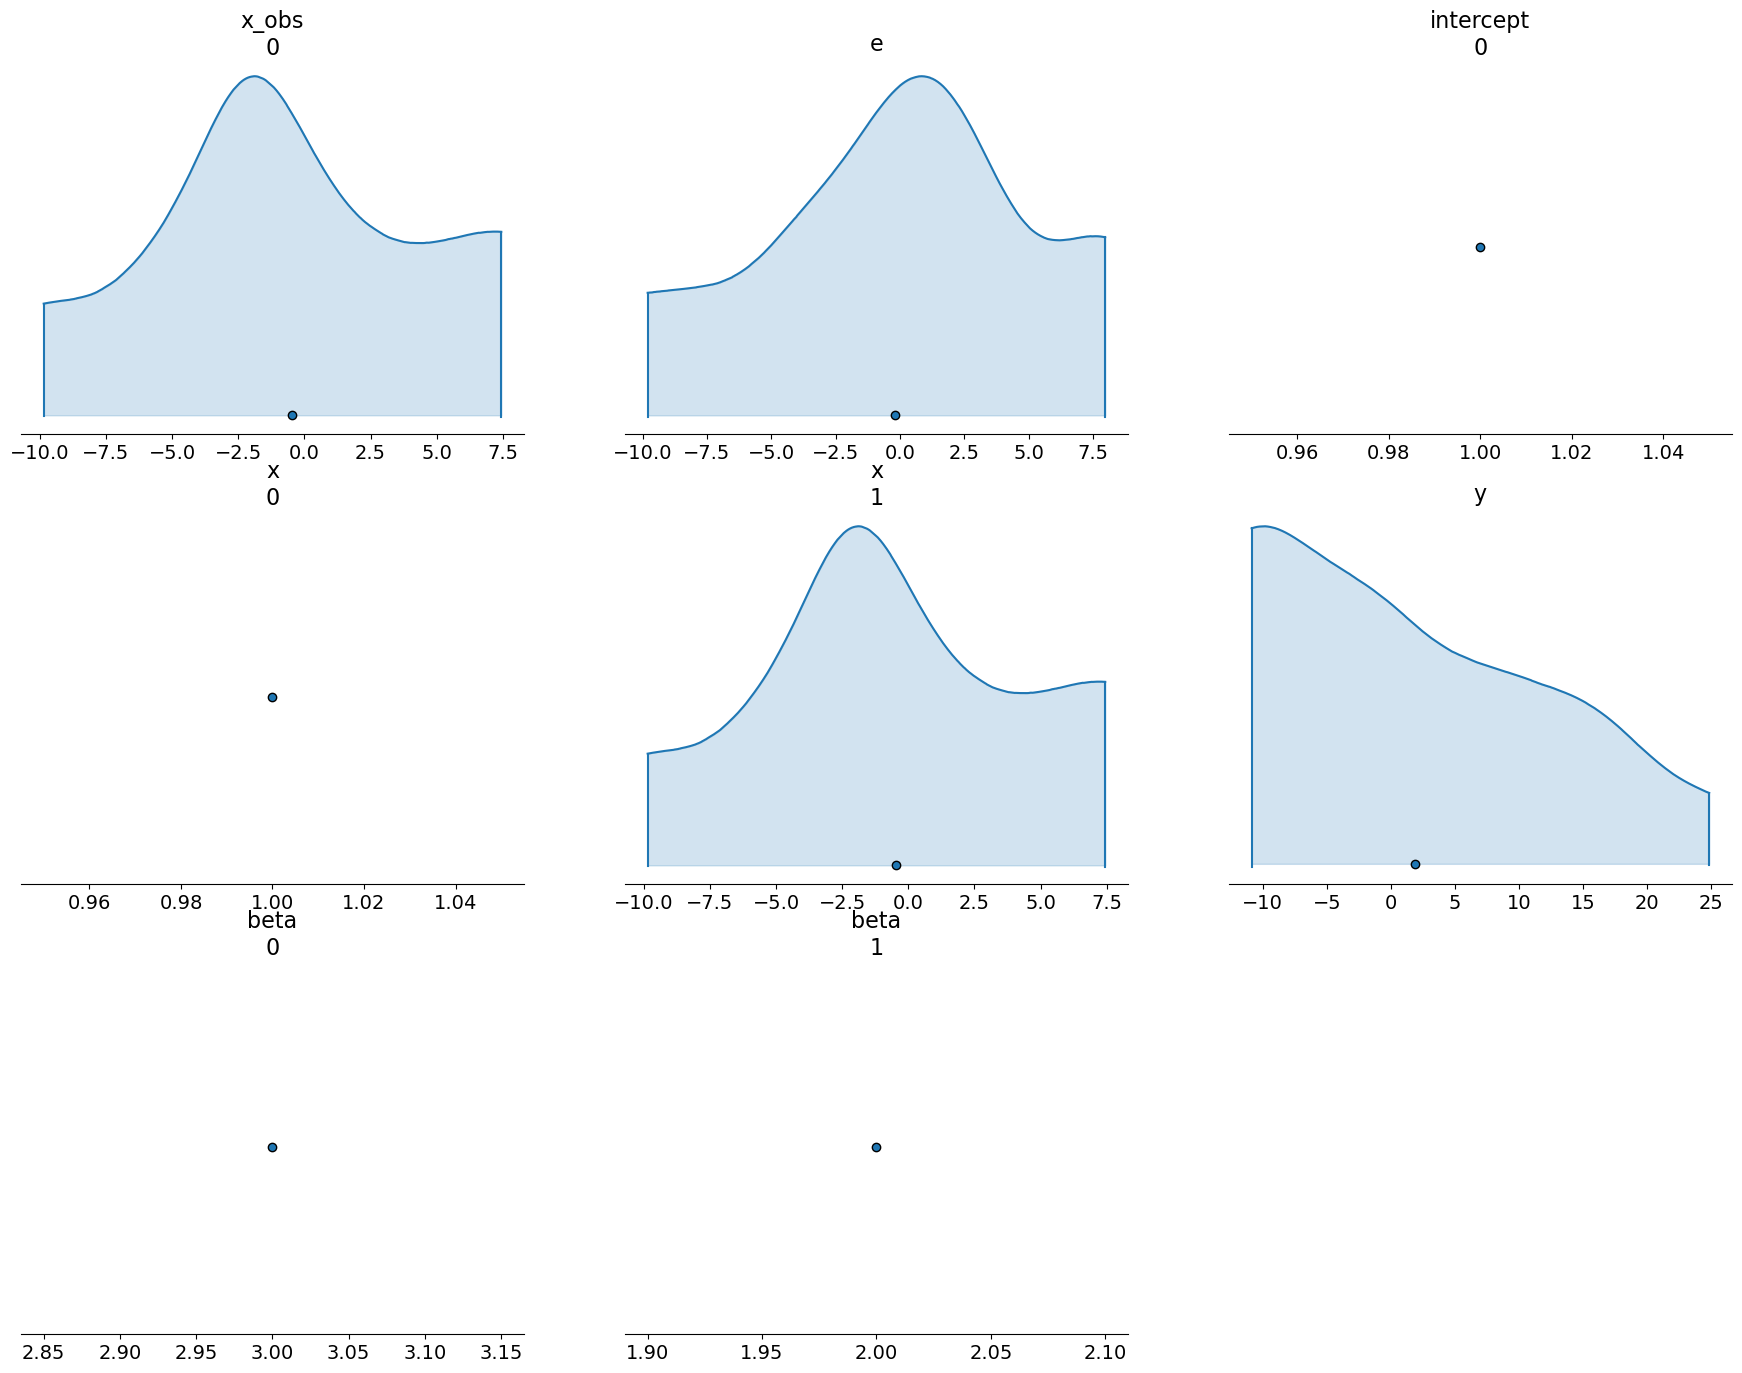

In [5]:
with pm.Model() as reg_model:
    # Known model parameter
    beta: pt.TensorConstant = pm.Deterministic("beta", pm.math.constant([3., 2.]))

    # Data and error distribution
    intercept: pt.TensorConstant = pm.Deterministic("intercept", pm.math.ones(shape=(1,)))
    x_obs: pt.TensorVariable = pm.Normal("x_obs", mu=0, sigma=4, shape=(1,))
    x: pt.TensorVariable = pm.Deterministic("x", pt.concatenate([intercept, x_obs]))
    e: pt.TensorVariable = pm.Normal("e", mu=0, sigma=5)

    # Simulated observations
    y: pt.TensorVariable = pm.Deterministic("y", pt.sum(x * beta) + e)

data: xr.Dataset = pm.sample_prior_predictive(draws=50, model=reg_model)
pytensor.dprint(y)
az.plot_density(data.prior, shade=0.2, backend="matplotlib")
data

Here is a plot of the data along with a line showing the true underlying data generating process.

In [ ]:
def plot_residual_line(
    pos: np.array, 
    ax_in: plt.Axes, 
    est_func: Callable[[float], float] = lambda x: 3 + 2 * x
) -> plt.Line2D:
    x_coord: float = pos[0]
    y_coord: float = pos[1]
    y_dgp: float = est_func(x_coord)
    ax_in.plot([x_coord, x_coord], [y_coord, y_dgp], color="grey", alpha=0.3)

def plot_best_fit(x: np.array, y: np.array, intercept: float, slope: float) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(8, 6))
    data_plot: plt.Axes = sb.scatterplot(
        x=x,
        y=y,
        ax=ax
    )
    dgp_plot: plt.Axes = ax.axline(
        xy1=(0, 3),
        slope=2,
        color="red",
        linestyle="--",
    )

    ax.axline(
        xy1=(0, intercept),
        slope=slope,
        color="red",
        linestyle="--",
        alpha=0.5
    )

    for data_pos in data_plot.collections[0].get_offsets():
        plot_residual_line(data_pos, ax_in=ax, est_func=lambda x: intercept + slope * x)

    ax.set_xlim(-10, 10)
    ax.set_ylim(-15, 15)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Joint distribution of x and y")
    plt.show()
    
plot_sample_size: int = 20
x=np.random.choice(data.prior.x_obs.values.flatten(), size=plot_sample_size)
y=np.random.choice(data.prior.y.values.flatten(), size=plot_sample_size)
interactive_plot = interact(
    plot_best_fit,
    x=fixed(x),
    y=fixed(y),
    intercept=FloatSlider(min=-10, max=10, step=0.2, value=3),
    slope=FloatSlider(min=-10, max=10, step=0.2, value=2),
)
# interactive_plot.children[-1].layout.height = '500px'

interactive(children=(FloatSlider(value=3.0, description='intercept', max=10.0, min=-10.0, step=0.2), FloatSli…

In [40]:
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.plotting import figure, show

x = [x*0.05 for x in range(-200, 200)]
y = x

dgp = ColumnDataSource(data=dict(x=x, y=y))
est = ColumnDataSource(data=dict(x=x, y=y))

plot = figure(width=400, height=400, x_range=(-5, 5), y_range=(-5, 5))

plot.line('x', 'y', source=dgp, line_width=3, line_alpha=0.6)
plot.line('x', 'y', source=est, line_width=3, line_alpha=0.6, color="red")

slope_slider = Slider(start=-5., end=5, value=1, step=.1, title="slope")
intercept_slider = Slider(start=-5., end=5, value=0, step=.1, title="intercept")
callback = CustomJS(args=dict(source=est, slope=slope_slider, intercept=intercept_slider), code="""
    console.log(cb_obj)
    console.log(slope.value)
    console.log(intercept.value)
    const f = cb_obj.value
    const x = source.data.x
    const y = Array.from(x, (x) => x * slope.value + intercept.value)
    source.data = { x, y }
""")


slope_slider.js_on_change('value', callback)
intercept_slider.js_on_change('value', callback)

layout = column(slope_slider, intercept_slider, plot)

show(layout)